## Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

## 1) Downloading the Data

In [2]:
# We are downloading to the data/ folder in this repository

%mkdir data
# %cd data/

A subdirectory or file data already exists.


In [3]:
# Setting metadata for download
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "data/"

In [4]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'mimetype': 'image/png'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'mimetype': 'text/plain'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'mimetype': 'text/x-python'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://n

In [5]:
%%time

# Download the file "data.zip"
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 6.38 s
Wall time: 29min 30s


In [6]:
%%time

# Unzip the CSVs from the zip file
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: total: 15.2 s
Wall time: 1min 8s


In [8]:
# View files that were extracted
%ls -ltr data

 Volume in drive C is OS
 Volume Serial Number is 1837-1226

 Directory of c:\Users\timot\OneDrive - UBC\Documents\Semester 2\Block 6\525\rainfall-predictor


 Directory of c:\Users\timot\OneDrive - UBC\Documents\Semester 2\Block 6\525\rainfall-predictor\data

25/03/2025  02:34 pm    <DIR>          .
24/03/2025  12:18 pm    <DIR>          ..
25/03/2025  02:34 pm    <DIR>          __MACOSX
25/03/2025  02:33 pm       127,613,760 ACCESS-CM2_daily_rainfall_NSW.csv
25/03/2025  02:33 pm       114,707,410 ACCESS-ESM1-5_daily_rainfall_NSW.csv
25/03/2025  02:33 pm        94,960,113 AWI-ESM-1-1-LR_daily_rainfall_NSW.csv
25/03/2025  02:33 pm       294,260,911 BCC-CSM2-MR_daily_rainfall_NSW.csv
25/03/2025  02:34 pm        55,224,437 BCC-ESM1_daily_rainfall_NSW.csv
25/03/2025  02:34 pm        46,286,371 CanESM5_daily_rainfall_NSW.csv
25/03/2025  02:33 pm       330,360,682 CMCC-CM2-HR4_daily_rainfall_NSW.csv
25/03/2025  02:34 pm       328,787,320 CMCC-CM2-SR5_daily_rainfall_NSW.csv
25/03/2025  02:33

File Not Found


## 2) Combining CSVs

In [26]:
%%time

# Combine
use_cols = ["time", "lat_min", "lat_max", "lon_min", "lon_max", "rain (mm/day)"]
files = glob.glob('data/*.csv')
df = pd.concat(pd.read_csv(file, index_col=0, usecols=use_cols)
                .assign(model=re.findall(r"data\\([^_]*)", file)[0])    # Extra data\ to account for Windows file scheme
                for file in files
              )
df.to_csv("data/combined_data.csv")

CPU times: total: 10min 42s
Wall time: 12min 17s


**Time Comparison with Lab Members**

| preferred lab partner(s) | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Timothy Singh | Windows 11 Home | 16GB | Intel i7-11800H | Yes |  10 minutes |
| Benjamin Frizzell  | MacOS  | 8GB | Intel i5 Duo Core |  Yes | 3 minutes  |
| Stephanie Ta   | Windows 10  | 16GB  | Intel i7-1065G7  |  Yes  | 4 minutes |
| Meagan Gardener   |  MacOS  |  16GB  | Apple M3   |  Yes  | 3 minutes |

## 3) Load the combined CSV to memory and perform a simple EDA


Here, we will load the data in chunks, getting rid of the `lat_min`, `lat_max`, `lon_min` and `lon_max` columns, and convert values in the `rain (mm/day)` column to `float32`

In [ ]:
%%time

# Load only "time". "model" and "rain (mm/day) columns, with 
# "time" as datetime, "model" as string and "rain (mm/day) as float32
# Also read as chunks, and perform EDA on each chunk

usecols = ["time", "rain (mm/day)", "model"]
dtypes = {"time": "string",
          "rain (mm/day)": "float32",
          "model": "string"}
          
value_counts = pd.Series(dtype=int)
rainfall_total = pd.Series(dtype=float)

for chunk in pd.read_csv("data/combined_data.csv",
    usecols = usecols,
    dtype = dtypes,
    parse_dates=["time"] ,
    chunksize=1_000_000
):
    value_counts = value_counts.add(chunk["model"].value_counts(), fill_value=0)
    rainfall_total = rainfall_total.add(chunk.groupby("model")["rain (mm/day)"].sum(), fill_value=0)

CPU times: total: 4min 43s
Wall time: 4min 47s


,0
3.454034e+06,<NA>
3.571729e+06,<NA>
1.958036e+06,<NA>
5.924474e+06,<NA>
9.994724e+05,<NA>
8.071704e+06,<NA>
8.440127e+06,<NA>
8.024869e+06,<NA>
1.045442e+06,<NA>
4.605362e+06,<NA>


In [49]:
eda_summary = pd.DataFrame({
    "model": rainfall_total.index,
    "rainfall_total": rainfall_total.values,
    "values_count": value_counts.values
    }
)

eda_summary

,model,rainfall_total,values_count
0,ACCESS-CM2,3.454034e+06,1932840.0
1,ACCESS-ESM1-5,3.571729e+06,1610700.0
2,AWI-ESM-1-1-LR,1.958036e+06,966420.0
3,BCC-CSM2-MR,5.924474e+06,3035340.0
4,BCC-ESM1,9.994724e+05,551880.0
5,CMCC-CM2-HR4,8.071704e+06,3541230.0
6,CMCC-CM2-SR5,8.440127e+06,3541230.0
7,CMCC-ESM2,8.024869e+06,3541230.0
8,CanESM5,1.045442e+06,551880.0
9,EC-Earth3-Veg-LR,4.605362e+06,3037320.0


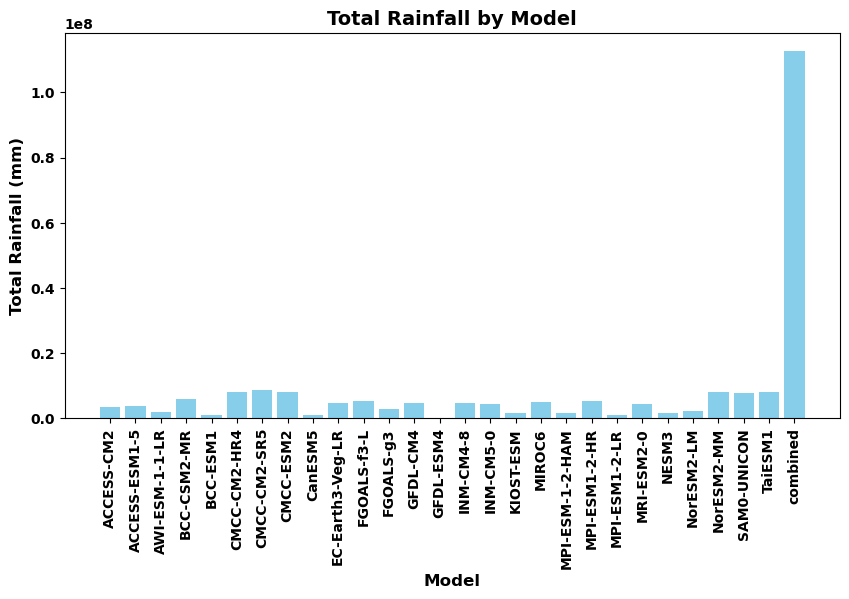

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(eda_summary["model"], eda_summary["rainfall_total"], color="skyblue")

# Titles and labels
plt.title("Total Rainfall by Model", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Total Rainfall (mm)", fontsize=12)
plt.xticks(rotation=90)  

plt.show();


**Time Comparison with Lab Members**

| preferred lab partner(s) | Operating System | RAM | Processor | Is SSD | Time taken | Methods used for Loading |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|:---------------------------:|
| Timothy Singh | Windows 11 Home | 16GB | Intel i7-11800H | Yes |  5 minutes | Only relevant columns, data type conversion, chunk loading |
| Benjamin Frizzell  | MacOS  | 8GB | Intel i5 Duo Core |  Yes | 1 minute  | Only relevant columns, data type conversion, parquet file saving |
| Stephanie Ta   | Windows 10  | 16GB  | Intel i7-1065G7  |  Yes  | 1 minute | Only relevant columns, data type conversion | 
| Meagan Gardener   |  MacOS  |  16GB  | Apple M3   |  Yes  | 20 seconds | Q |

## 4) Perform a simple EDA in R

In [ ]:
%%time
import pyarrow.dataset as ds

df = ds.dataset(filepathcsv, format="csv")
result = df.scanner(columns=use_cols)
ds.write_dataset(result,filepathparquet,format = "parquet",partitioning=["year"],partitioning_flavor="hive", existing_data_behavior = 'overwrite_or_ignore')